# Strategy

>1. According to you, in which application area will we see the first demonstration of quantum advantage and why? Try to take into account the latest advances in algorithm and hardware development when presenting your answer.

## Quantum advantage:

First, I find it is necessary to lay out my criteria for a quantum computing application to meet before achieving quantum advantage:

- It is executed on available quantum hardware,
- Its solution can be well verified,
- The solution provided requires less computation than the state-of-the-art classical method for the same accuracy and solution goodness.

## Applications:

With these three criteria, I will analyse the leading candidates for quantum advantage, namely: sampling, quantum chemistry, simulation and optimization.

### Sampling:

It is known that sampling from particular probability distributions is computationally challenging for classical computers, while quantum computers are well suited to such tasks due to their probabilistic nature. 
Samples produced from random quantum circuits uniformly cover the Hilbert space and therefore the dimensionality of the target distribution scales exponentially with system size. 
Sampling problems that are infeasible on a classical computer have been performed on Google's Sycamore (@arute2019quantum, @morvan2024phase) and the Quantinuum’s H2 device (@decross2025computational). 
However, the presence of noise in quantum hardware restricts the sampling to subspaces of the Hilbert space and remove this guarantee of quantum advantage, as discussed in @aharonov2023polynomial.
Unfortunately, directly comparing the output distribution to that of a Thomas-Porter distribution (produced from the uniform sampling over the Hilbert space) is computationally diffucult, and calculating measures to determine if it is ‘close enough’ leave room for ambiguity. 

### Quantum chemistry:

Determining the ground state energy of a given Hamiltonian is an important problem in chemistry and physics. 
Due to the exponential size of the energy landscape, classical computers are limited to analysing very small system sizes. There has been much interest into the application of the variational quantum eigensolver (VQE) algorithms to perform this task (@peruzzo2014variational). 
This variational approach allows for its application on near-term noisy devices. State-of-the-art methods, like the sample-based Krylov quantum diagonalization algorithm, have been shown to converge to a solution in polynomial time for certain Hamiltonians (@yu2501quantum). 
The energy of the output solution can be calculated and verified against that produced from a classical method. 
However, all VQE methods rely on the assumption that they have access to an initial state that has some degree of overlap with the ground state. 
The idea of *warm starting* problems of optimisation in this way is not singular, however there is no guarantee obtaining such approximate ground state solutions efficiently is computationally feasible for all problems in chemistry, and proves to be a roadblock for many real applications of VQE.

### Simulation:

Using quantum computers to simulate target Hamiltonians was the first proposed use of the devices. 
To explore the time evolution of a complex quantum system, it is reasonable to construct an approximate Hamiltonian in a controlled environment, and to analyse the observables it produces. 
The better that the approximation to the quantum systems true Hamiltonian is made, the better the simulation becomes. 
Exact diagonalization of the system becomes quickly infeasible on a classical computer, and are limited in long time evolutions of Hamiltonians when pushed to extreme conditions such as the approach of a phase transition. 
This task is especially well suited to near-term analog quantum computers that evolve an inbuilt Hamiltonian to perform their computation, and therefore allow for simulations of Hamiltonians that their native Hamiltonian can well approximate (@choi2016exploring @king2024computational @andersen2025thermalization), but can also be approximated on digital hardware through Trotterization (@kim2023evidence, plus see technical problem 1). 
The problem with quantum simulation is similar to that of sampling, where the presence of noise in the quantum device introduces ambiguity to the output, and verification of the results becomes challenging. 
The effects of this noise can be somewhat reduced with current error mitigation techniques, as demonstrated in @kim2023evidence. 
However, this only applies to regimes where the noise is well behaved and before it dominates observables.

### Optimisation:

Combinatorial optimisation problems are ubiquitous in industry and are exponential in solution space to problem size. 
Solutions to optimization problems can be easily verified once produced, allowing for a straightforward comparison between quantum and classical methods. 
Both classical and quantum algorithms that guarantee exact solutions are prohibited due to the NP-hardness of the problems and instead rely on heuristic methods. 
This allows room for quantum advantage to be potentially demonstrated for optimization problems on a case-by-case basis. QAOA is a variational heuristic approach, making it well suited to noisy near-term devices @farhi2014quantum. 
Optimization problems such as finding the maximum independent set are well suited to the native Hamiltonian of neutral atom devices, where it has been identified regimes for which state-of-the-art classical optimization methods fail @cazals2025identifying. 
While it was identified that system sizes towards 1000 would be required before advantage could be reached, this is in the projection of current hardware development.

## Discussion:

From the points discussed above, I believe that convincing quantum advantage is most achievable on near-term devices through optimisation problems.
This is due to the applicability of such problems to current hardware, the ease at which solutions can be verified, and the potential of algorithms such as QAOA to challenge current classical methods despite hardware noise (see @zhou2020quantum and technical problem 3).
While heuristic quantum methods like QAOA do not guarantee that classical methods cannot exist that outperform them, the vast number of industrially relevant optimization problems offer much potential for quantum advantage to be sought. 
Additionally, classical optimisation algorithms for such problems have been studied extensively due to their demand. 
Therefore any improvements over current classical methods would likely be a long-standing demonstration of quantum advantage, and provide immediate utility in industry.

Applications in sampling and simulation may become more favourable avenues for quantum advantage in coming years, with the progress of noise-reduced hardware and error correction to bring about fault-tolerant quantum computing, as demonstrated for random circuit sampling in @bluvstein2024logical. 
With a reduction in the effects of noise, the solutions provided to problems in sampling and simulation will become more trustworthy and remove the ambiguity in their verification.

I therefore believe that a roadmap to quantum advantage should include both applications in optimization and future plans of fault-tolerant applications through the development of error correction methods.

# Technical

> 1. Consider the Heisenberg model on a 1D lattice with nearest neighbor interactions. Construct a circuit that allows you to do a Trotterized time-evolution of this Hamiltonian using single qubit rotations and CNOT gates. Make it as efficient in the number of 2-qubit gates and circuit depth as you can. Then use a quantum software framework of your choice (for example, Qiskit or Cirq) to implement this and show the code.

I consider a general 1D Heiseinberg model Hamiltonian with all nearest-neighbour coupling ($J_x$, $J_y$, $J_z$) and field ($h_x$, $h_y$, $h_z$) terms of the form:

$$
H = \sum^{n-2}_{i=0} (J_x\hat{\sigma}^x_i\hat{\sigma}^x_{i+1} + J_y\hat{\sigma}^y_i\hat{\sigma}^y_{i+1} + J_z\hat{\sigma}^z_i\hat{\sigma}^z_{i+1}) + \sum^{n-1}_{j}(h_x\hat{\sigma}^x_i + h_y\hat{\sigma}^y_i + h_z\hat{\sigma}^z_i).
$$

To approximate this, I assume a second-order Suzuki–Trotter expansion.
The individual coupling terms can be broken down into RXX, RYY and RZZ gates that each require 2 CNOT gates each.
The edges of the graph associated with 1D chain has two colours, corresponding to odd and even sites, and can therefore be treated with two-qubit gates independently allowing for their application to be parallelized.

In [ ]:
#| code-fold: True

import numpy as np

from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import Statevector

from tenpy.models.spins import SpinChain
from tenpy.networks.mps import MPS
from tenpy.algorithms.tebd import TEBDEngine
from tenpy.algorithms.exact_diag import get_full_wavefunction

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [2]:
#| code-fold: False
#| code-summary: "Show the code"

def RXX_gate(circ, q1, q2, theta):
    '''
    circ:    QuantumCircuit object to apply RXX gate to
    q1:      First qubit
    q2:      Second qubit
    theta:   Rotation angle

    returns: QuantumCircuit object with RXX gate applied to qubits q1 and q2
    '''
    circ.h(q1)
    circ.h(q2)
    circ.cx(q1, q2) # First CNOT
    circ.rz(theta, q2)
    circ.cx(q1, q2) # Second CNOT
    circ.h(q1)
    circ.h(q2)

    return circ

def RYY_gate(circ, q1, q2, theta):
    '''
    circ:    QuantumCircuit object to apply RYY gate to
    q1:      First qubit
    q2:      Second qubit
    theta:   Rotation angle

    returns: QuantumCircuit object with RYY gate applied to qubits q1 and q2
    '''
    circ.sx(q1).inverse()
    circ.sx(q2).inverse()
    circ.cx(q1, q2) # First CNOT
    circ.rz(theta, q2)
    circ.cx(q1, q2) # Second CNOT
    circ.sx(q1)
    circ.sx(q2)

    return circ

def RZZ_gate(circ, q1, q2, theta):
    '''
    circ:    QuantumCircuit object to apply RZZ gate to
    q1:      First qubit
    q2:      Second qubit
    theta:   Rotation angle

    returns: QuantumCircuit object with RZZ gate applied to qubits q1 and q2
    '''
    circ.cx(q1, q2) # First CNOT
    circ.rz(theta, q2)
    circ.cx(q1, q2) # Second CNOT

    return circ

def HModel_trot(circ, qreg, T, J, h, nstep=1, PBC=True, wrap=False, 
                inverse=False, label='Hberg trot'):
    '''
    A quantum circuit approximating a 1D nearest-neighbour Heisenberg model 
    using a second-order Suzuki–Trotte decomposition.
    
    circ:    QuantumCircuit object that the Trotterized Heisenberg model is 
             applied to.
    qreg:    QuantumRegister object of n qubits.
    T:       Evolution time.
    J:       Coupling terms of Hamiltonian that are either a list [Jx, Jy, Jz] 
             or a float such that J=Jx=Jy=Jz.
    h:       Field strength terms of Hamiltonian that are either a list 
             [hx, hy, hz] or a float such that hx=hy=0 and h=hz.
    nstep:   Number of steps to the Trotterization (int) default nstep=1.
    PBC:     Apply periodic bounadry conditions (bool) default PBC=True.
    wrap:    Convert output into Gate object (bool) default wrap=False.
    inverse: Return inverted Gate object (bool) default inverse=False.
    label:   Label to name wrapped gate (str) default label='Hberg trot'.
    
    returns: QuantumCircuit object with RZZ gate applied to qubits q1 and q2 
             or Gate object if wrap=True.
    '''
    try:
        if len(J)!=3:
            raise ValueError('Coupling terms J must be a single digit '
            'or a list of three values.')
        else:
            Jx, Jy, Jz = J

    except TypeError:
        Jx, Jy, Jz = J, J, J

    try:
        if len(h)!=3:
            raise ValueError('Field strength terms h must be a single digit '
            'or a list of three values.')
        else:
            hx, hy, hz = h

    except TypeError:
        hx, hy, hz = 0, 0, h


    n = len(qreg)

    if inverse:
        wrap = True

    if wrap: 
        # If wrap, define new QuantumRegister and QuantumCircuit 
        # to apply operations to
        qreg = QuantumRegister(n, 'qreg')
        circ = QuantumCircuit(qreg)

    start = -int(PBC)

    for k in np.arange(nstep): 
        # Loop through all trotter steps for the first half of the T
        # rotter application with 1/2 angles
        for i in np.arange(start,n-1)[::2]: 
            # First apply all gates of odd(even) sites 
            # (depending on if PBC=True)
            if Jx!=0.:
                circ = RXX_gate(circ, qreg[i], qreg[i+1], T*Jx/nstep)
            if Jy!=0.:
                circ = RYY_gate(circ, qreg[i], qreg[i+1], T*Jy/nstep)
            if Jz!=0.:
                circ = RZZ_gate(circ, qreg[i], qreg[i+1], T*Jz/nstep)
        for i in np.arange(start+1,n-1)[::2]: 
            # Then apply all gates of even(odd) sites
            if Jx!=0.:
                circ = RXX_gate(circ, qreg[i], qreg[i+1], T*Jx/nstep)
            if Jy!=0.:
                circ = RYY_gate(circ, qreg[i], qreg[i+1], T*Jy/nstep)
            if Jz!=0.:
                circ = RZZ_gate(circ, qreg[i], qreg[i+1], T*Jz/nstep)

    for i in np.arange(start,n-1): # Loop through single qubit operations
        if hx!=0.:
            circ.rx(T*hx, qreg[i])
        if hy!=0.:
            circ.ry(T*hy, qreg[i])
        if hz!=0.:
            circ.rz(2*T*hz, qreg[i])
        if hy!=0.:
            circ.ry(T*hy, qreg[i])
        if hx!=0.:
            circ.rx(T*hx, qreg[i])

    for k in np.arange(nstep): 
        # Loop through all trotter steps for the second half of the 
        # Trotter application with 1/2 angles
        for i in np.arange(start+1,n-1)[::2]: 
            # Apply all gates of even(odd) sites
            if Jz!=0.:
                circ = RZZ_gate(circ, qreg[i], qreg[i+1], T*Jz/nstep)
            if Jy!=0.:
                circ = RYY_gate(circ, qreg[i], qreg[i+1], T*Jy/nstep)
            if Jx!=0.:
                circ = RXX_gate(circ, qreg[i], qreg[i+1], T*Jx/nstep)
        for i in np.arange(start,n-1)[::2]: 
            # Then apply all gates of odd(even) sites
            if Jz!=0.:
                circ = RZZ_gate(circ, qreg[i], qreg[i+1], T*Jz/nstep)
            if Jy!=0.:
                circ = RYY_gate(circ, qreg[i], qreg[i+1], T*Jy/nstep)
            if Jx!=0.:
                circ = RXX_gate(circ, qreg[i], qreg[i+1], T*Jx/nstep)
    
    if wrap:
        circ = circ.to_gate()
        circ.label = label

    if inverse:
        circ = circ.inverse()
        circ.label = label+'\dag'

    return circ

>2. Consider the QAOA algorithm applied to the MaxCut problem on 3-regular graphs. Suppose you have a square lattice of qubits with nearest neighbor connectivity. Describe an algorithm and write commented pseudocode that allows you to map the qubits in the QAOA circuit to the physical qubit layout and schedule the circuit in the most efficient way you can come up with. Do a theoretical or numerical analysis of the time complexity of the schedule.

We have a 3-regular problem graph $G$ with edges $E$ and $n$ vertices $V$, and a square lattice of spacing $a$ and $L\times L=N$ qubits, where $N\ge n$ with nearest neighbour interactions, described by graph $G'$. 

First, we map the graph vertices to the qubits in the lattice. This should be done through a breadth-first search algorithm to minimize the number of edges between vertices that are assigned between non-local (beyond nearest-neighbour) qubits.
If $G$ is a planar graph, then the embedding becomes trivial as the connectivity of the nearest neighbour square lattice is greater than the problem graph. 
However, if we have edges between vertices that are non-local that we wish to embed, we will require a subroutine to the QAOA.
If we have two non-local qubits that correspond to two vertices that share an edge, we can apply a chain of SWAP gates between neighbouring qubits to allow for connections between the two qubits. 
The furthest two qubits would require $2L$ SWAP gates to connect one another. 
These chains of SWAP gates must be applied in succession, but SWAP gate chains for different non-local connections may be done in parallel. 
The SWAP gate application is inverted with the same number of operations.
The application of the problem Hamiltonian in the QAOA algorithm requires two-qubit gates, the number of which scales with the number of graph edges. 
Edges that do not share vertices can be applied in parallel, so the maximum required two-qubit depth of the QAOA circuit is equal to the chromatic index of the graph, which is a maximum of 4. 
The assignment of edges to each of the colours, in order to parallelize this process, can be done as a preprocessing step. 

```
--------------------------------------------------------------------------------------
# Return a dictionary linking vertices of G to corresponding lattice positions
mapping = breadth_first_search(G, G')

# Returns a list of arrays of all edges with the same colour
edge_colorings = cuthill_mckee_algorithm(G)

# Define an empty list to save circuit to
circuit = []

for i in p: # Loop through assigned number of layers p

    # Append to circuit list the mixing Hamiltonian
    circuit.append(qaoa_mixing_hamiltonian(beta[i]))

    for edges_of_color in edge_colorings: # Loop through edge colours

        for edge in edges_of_color: # Loop through each edge (executed in parallel)

            # dist() returns the Euclidean distance between two points
            if dist(mapping[edge[0]]-mapping[edge[1]])>a:

                # Determine the chain of SWAP gates between the two points
                swap_gate_chain = shortest_swap_path(mapping[edge])
                circuit.append(swap_gate_chain)

            # Append to circuit the problem Hamiltonian
            circuit.append(qaoa_problem_hamiltonian(edge, gamma[i]))

            # Invert the SWAP gate chain application
            if dist(mapping[edge[0]]-mapping[edge[1]])>a:
                circuit.append(swap_gate_chain.inverse)

--------------------------------------------------------------------------------------
```

The computational cost of the mapping (assuming a breadth-first search eg. Cuthill-McKee algorithm @cuthill1969reducing) scales $O(|E|+|V|)=O(n)$. The Misra & Gries edge-coloring algorithm can be performed in $O(|E|)=O(n)$ steps according to @assadi2025vizing. 
Each QAOA layer will consist of two applications of SWAP gate chains, which (if we assume $n=N$), is upper-bounded by $O(\sqrt{n})$. 
The problem Hamiltonian application has constant depth of max 4. Therefore the computational cost of $p$ layers of QAOA scales $O(p \sqrt{n})$.

>3. Consider the QAOA algorithm. For uniform graphs, there is numerical evidence (https://arxiv.org/pdf/1812.01041.pdf) that the approximation ratio will increase exponentially with the number of layers in the algorithm. Assuming this is true, let’s say you have a quantum computer in which depolarizing noise affects each 2-qubit gate. Analyze how the approximation ratio behaves as a function of the strength of the noise and the number of layers.

A two-qubit depolarizing noise channel introduces some probability $\lambda$ of applying one of 15 Pauli errors for each 2-qubit gate implementation.
If we apply this to every gate in the QAOA application this will evolve the state towards the maximally mixed state over successive layers at a rate $R$ dependent on $\lambda$.
Each problem Hamiltonian application applies a number of two-qubit gates proportional to the number of edges of the problem graph, which will scale with the system size $n$.
The paper @zhou2020quantum numerically fits the approximate ratio $r$ and number of layer relation for the unweighted graph types with an exponential fit:

$$
r(p) = 1-r_{0}e^{-\alpha p},
$$

where $r_0$ is the approximate ratio at $p=0$ which is equal to the average approximate ratio from drawing uniform solutions to the problem Hamiltonian, and $\alpha$ is the nuermically fitted slope. 
Similarly, the approximate ratio resulting from the maximally mixed state that the noisy system approaches at $p\rightarrow \infty$ is also equal to $r_0$.
Therefore lets assume the depolarizing noise channel will introduce an exponential decay to the approximate ratio of the form:

$$
r(p) = r_0(1 - e^{-\beta p}) + (1 - r_{0}e^{-\alpha p})e^{-\beta p},
$$

where I've introduced an additional rate term $\beta$ as the decay rate due to the polarzing noise, proportional to the system size $n$ and $\lambda$ through constant $k$.
We can determine the QAOA layer that maximizes this function $p_{\text{max}}$ through the first derivative, giving the result:

$$
p_{\text{max}} = \frac{1}{\alpha}\left(\ln\left(1+\frac{\alpha}{\lambda k n}\right)+\ln\left(\frac{r_0}{1-r_0}\right)\right).
$$

We can see that increasing the error probability $\lambda$ results in the approximate ratio reaching its maximum with fewer layers.
Additionally, larger system sizes result in each QAOA layer to be deeper, and therefore decreases the number of layers before the maximum approximate ratio is reached.

Let us look at how the error rate $\beta$ must compare to the QAOA rate $\alpha$ in order to provide an approximate ratio that exceeds that of the Goemans-Williamson algorithm of $r_{\text{GW}}\approx 0.9326$ for 3-regular graphs (@goemans1995improved). 
Define $\gamma=\beta/\alpha$ and we can allow $r_0\approx0.5$ as it should be for MaxCut problems, then the maximum approximate ratio acheived is:

$$
r_{\text{max}} = \frac{1}{2}\left(1+\frac{\gamma^\gamma}{(\gamma+1)^{\gamma+1}}\right).
$$

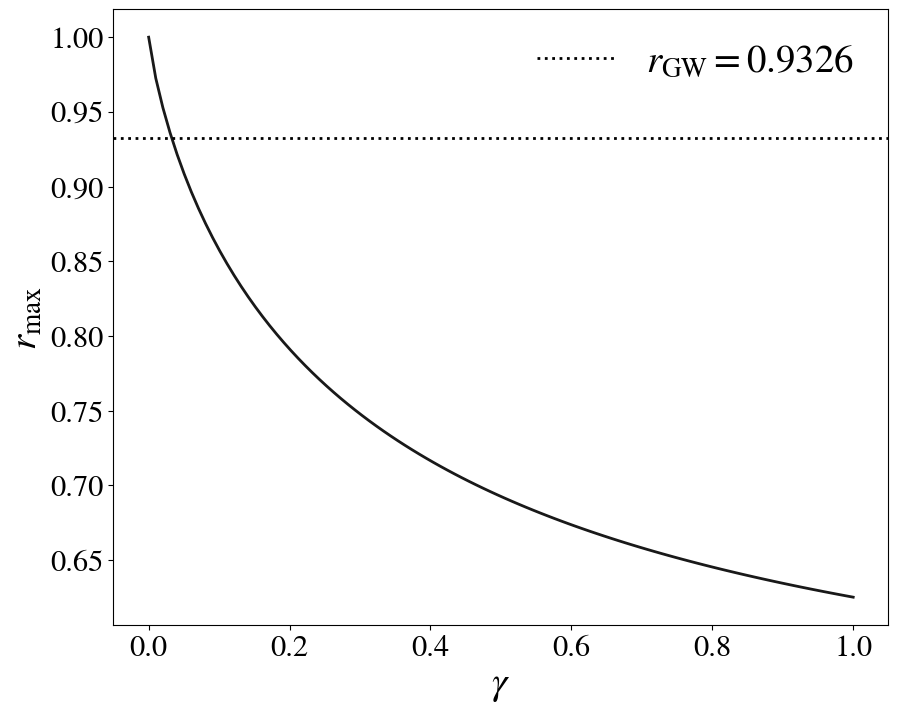

In [ ]:
#| code-fold: True
#| label: fig-rmax
#| fig-cap: Plot of the maximum approximate ratio $r_{\text{max}}$ over ratio of depolarizing to QAOA approximate ratio improvement rate $\gamma$. With $\gamma<0.1$ the $r_{\text{max}}$ exceeds that from the Goemans-Williamson bound of 0.87856.

def r_max(x):
    return (1+np.power(x,x)/np.power(x+1,x+1))/2.

gammas = np.linspace(0,1,100)

fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.set_xlabel(r'$\gamma$', fontsize=fontsize)
ax.set_ylabel(r'$r_{\regular{max}}$', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=ticksize)

ax.plot(gammas, r_max(gammas), color='black', lw=2, alpha=0.9)
ax.axhline(0.9326, ls=':', lw=2, color='black', 
           label=r'$r_{\regular{GW}}= 0.9326$')

ax.legend(framealpha=0., fontsize=fontsize)

plt.show()

As seen in @fig-rmax, with $\gamma<0.032$, we can beat the Goemans-Williamson bound. 
Taking $\alpha=0.25$ at $n=20$ from the @zhou2020quantum requires an error rate of $k\lambda<4\times10^{-4}$ per gate.